# Logistic Regression with a Neural Network mindset

## 1 - Packages

In [3]:
"""
This module imports necessary libraries for data manipulation, 
image processing, and visualization.
"""

import h5py  # For handling HDF5 files
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting graphs
from PIL import Image  # For image processing
from scipy import ndimage  # For image filtering and transformations
from lr_utils import load_dataset  # Custom utility for loading datasets

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

## 2 - Overview of the Problem set

In [5]:
# Load the dataset containing cat/non-cat images and labels
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

# The dataset includes:
# - train_set_x_orig: Original training set features (images)
# - train_set_y: Labels for the training set (1 for cat, 0 for non-cat)
# - test_set_x_orig: Original test set features (images)
# - test_set_y: Labels for the test set (1 for cat, 0 for non-cat)
# - classes: Array containing class labels ('cat', 'non-cat')

y = 0, it's a 'non-cat' picture.


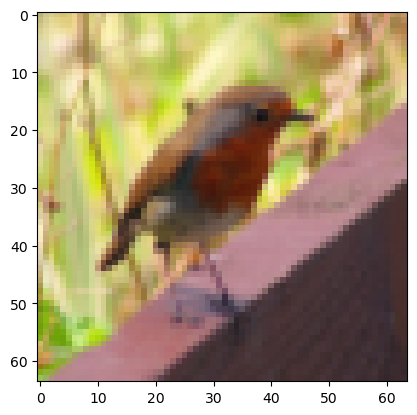

In [6]:
# Select the index of the image to display
index = 10

# Display the image from the training set at the specified index
plt.imshow(train_set_x_orig[index])

# Print the label for the selected image
# - train_set_y[0, index]: Retrieves the label (0 or 1) for the image
# - classes[np.squeeze(train_set_y[:, index])]: Converts the label into its corresponding class name ('cat' or 'non-cat')
# - decode("utf-8"): Converts the byte string to a regular string for printing
label = train_set_y[0, index]
class_name = classes[np.squeeze(train_set_y[:, index])].decode("utf-8")
print(f"y = {label}, it's a '{class_name}' picture.")

In [7]:
# Determine the number of training examples
m_train = train_set_x_orig.shape[0]

# Determine the number of testing examples
m_test = test_set_x_orig.shape[0]

# Determine the height/width (number of pixels) of each image (assuming square images)
num_px = train_set_x_orig.shape[1]

# Print the computed values with descriptive messages
print(f"Number of training examples: m_train = {m_train}")
print(f"Number of testing examples: m_test = {m_test}")
print(f"Height/Width of each image: num_px = {num_px}")

# Since images are square, the size of each image is (num_px, num_px, 3) where 3 represents the RGB channels
print(f"Each image is of size: ({num_px}, {num_px}, 3)")

# Print the shape of the training and testing datasets for both features (X) and labels (Y)
print(f"train_set_x shape: {train_set_x_orig.shape}")
print(f"train_set_y shape: {train_set_y.shape}")
print(f"test_set_x shape: {test_set_x_orig.shape}")
print(f"test_set_y shape: {test_set_y.shape}")

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [8]:
# Reshape the training and test examples into a 2D matrix
# Each image is flattened into a vector of size (num_px * num_px * 3)
# The resulting shape will be (flattened image size, number of examples)

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[1] * train_set_x_orig.shape[2] * train_set_x_orig.shape[3], train_set_x_orig.shape[0])
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[1] * test_set_x_orig.shape[2] * test_set_x_orig.shape[3], test_set_x_orig.shape[0])

# Print the shapes of the reshaped training and testing datasets
print(f"train_set_x_flatten shape: {train_set_x_flatten.shape}")
print(f"train_set_y shape: {train_set_y.shape}")
print(f"test_set_x_flatten shape: {test_set_x_flatten.shape}")
print(f"test_set_y shape: {test_set_y.shape}")

# Sanity check: Print the first five elements of the first training example after reshaping
print(f"Sanity check after reshaping: {train_set_x_flatten[0:5, 0]}")

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
Sanity check after reshaping: [17 71 49 38 70]


In [9]:
# Normalize the pixel values of the training and test sets by dividing by 255
# This scales the pixel values from the range [0, 255] to [0, 1], which can help improve model performance

train_set_x = train_set_x_flatten / 255.0
test_set_x = test_set_x_flatten / 255.0

## 4 - Building the parts of our algorithm

### 4.1 - Helper functions

In [12]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    """
    Compute the sigmoid of z.

    Args:
    z (np.ndarray): A scalar or numpy array of any size.

    Returns:
    np.ndarray: The sigmoid of z.
    """
    s = 1 / (1 + np.exp(-z))
    return s

In [13]:
# Print the result of the sigmoid function applied to the numpy array [0, 2]
# The result is converted to a string for concatenation with the message
print("sigmoid([0, 2]) = " + str(sigmoid(np.array([0, 2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


### 4.2 - Initializing parameters

In [15]:
def initialize_with_zero(dim: int) -> tuple[np.ndarray, float]:
    """
    Initializes a vector of zeros and a scalar.

    Args:
    dim (int): The size of the vector w to be initialized.

    Returns:
    tuple: A tuple containing:
        - w (np.ndarray): Initialized vector of shape (dim, 1).
        - b (float): Initialized scalar set to 0.
    
    Raises:
    ValueError: If dim is not a positive integer.
    """
    if dim <= 0:
        raise ValueError("Dimension must be a positive integer.")

    w = np.zeros((dim, 1))
    b = 0.0

    return w, b

In [16]:
# Set the dimensionality for the weights and bias
dim = 2

# Initialize weights (w) and bias (b) to zero using the specified dimension
w, b = initialize_with_zero(dim)

# Print the initialized weights
print ("w = " + str(w))

# Print the initialized bias
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0.0


### 4.3 - Forward and Backward propagation

In [18]:
def propagate(w: np.ndarray, b: float, X: np.ndarray, Y: np.ndarray) -> tuple:
    """
    Implements the cost function and its gradient for logistic regression.

    Args:
    w (np.ndarray): Weights, a numpy array of size (num_px * num_px * 3, 1).
    b (float): Bias, a scalar.
    X (np.ndarray): Data of size (num_px * num_px * 3, number of examples).
    Y (np.ndarray): True "label" vector (0 if non-cat, 1 if cat) of size (1, number of examples).

    Returns:
    tuple: A tuple containing:
        - grads (dict): A dictionary with gradients dw and db.
        - cost (float): Negative log-likelihood cost for logistic regression.
    """
    
    m = X.shape[1]  # Number of examples
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T, X) + b)  # Compute activation
    cost = -np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A)) / m  # Compute cost

    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = np.dot(X, (A - Y).T) / m  # Gradient with respect to w
    db = np.sum(A - Y) / m  # Gradient with respect to b

    # Assertions for debugging
    assert dw.shape == w.shape, "Gradient dw shape mismatch."
    assert isinstance(db, float), "Gradient db should be a float."
    cost = np.squeeze(cost)  # Ensure cost is a scalar
    assert cost.shape == (), "Cost should be a scalar."

    grads = {"dw": dw, "db": db}
    
    return grads, cost

In [19]:
# Initialize weight matrix w and bias b
w = np.array([[1.], [2.]])
b = 2.0

# Initialize input data 'X' and true labels 'Y'
X = np.array([[1., 2., -1], [3., 4., -3.2]])
Y = np.array([[1, 0, 1]])

# Call the propagate function to compute gradients and cost
grads, cost = propagate(w, b, X, Y)

# Extract the gradients from the dictionary
dw = grads["dw"]
db = grads["db"]

# Print the gradient w.r.t weights
print(f"dw = {dw}")

# Print the gradient w.r.t bias
print(f"db = {db}")

# Print the cost of the current model
print(f"cost = {cost}")

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


### 4.4 - Optimization

In [21]:
# optimize

# costs = 0

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    """
    Optimizes the parameters w and b using gradient descent.
    
    Arguments:
    w -- Weights, a numpy array of shape (num_px * num_px * 3, 1)
    b -- Bias, a scalar
    X -- Data of shape (num_px * num_px * 3, number of examples)
    Y -- True "label" vector (0 for non-cat, 1 for cat), of shape (1, number of examples)
    num_iterations -- Number of iterations for the optimization loop
    learning_rate -- Learning rate for gradient descent
    print_cost -- If True, prints the cost every 100 iterations
    
    Returns:
    params -- Dictionary containing the optimized weights w and bias b
    grads -- Dictionary containing the gradients of the weights and bias
    costs -- List of costs recorded during the optimization process
    """
    
    costs = []

    for i in range(num_iterations):
        
        # Compute cost and gradients using the propagate function
        grads, cost = propagate(w, b, X, Y)
        
        # Update weights and bias using gradient descent
        w -= learning_rate * grads["dw"]
        b -= learning_rate * grads["db"]
        
        # Record the cost every 100 iterations
        if i % 100 == 0:
            costs.append(cost)
            
            # Optionally print the cost
            if print_cost:
                print(f"Cost after iteration {i}: {cost:.6f}")

    # Store the updated parameters in a dictionary
    params = {"w": w, "b": b}
    
    # Store the gradients in a dictionary
    grads = {"dw": grads["dw"], "db": grads["db"]}
    
    return params, grads, costs

In [22]:
# Optimize the parameters using gradient descent
params, grads, costs = optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False)

# Print the optimized parameters and gradients
print(f"w = {params['w']}")
print(f"b = {params['b']}")
print(f"dw = {grads['dw']}")
print(f"db = {grads['db']}")

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067657


Costs: [5.801545319394553]


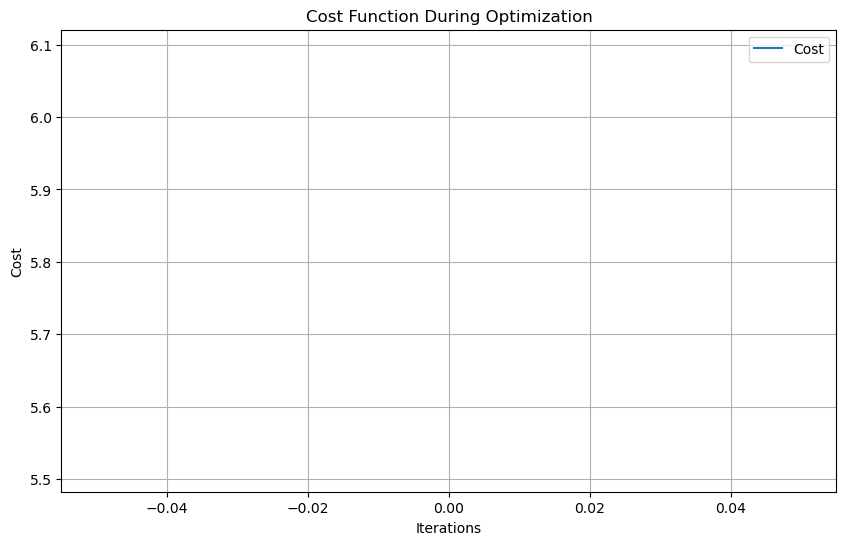

In [23]:
# Print the costs to inspect the values stored during optimization
print("Costs:", costs)

# Plot the cost values recorded during the optimization process
# 'costs' should be a list of cost values, each representing the cost
# after a certain number of iterations in the optimization loop.

plt.figure(figsize=(10, 6))  # Optional: Set the figure size for better visibility
plt.plot(costs, label='Cost')  # Plot the costs with a label for the legend
plt.xlabel('Iterations')       # Label for the x-axis
plt.ylabel('Cost')             # Label for the y-axis
plt.title('Cost Function During Optimization')  # Title for the plot
plt.legend()                   # Display the legend for the plot
plt.grid(True)                 # Optional: Add a grid for better readability
plt.show()                     # Display the plot


In [24]:
import numpy as np

def predict(w, b, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b).
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    """
    
    # Number of examples
    m = X.shape[1]
    
    # Ensure w is the correct shape to perform matrix multiplication
    w = w.reshape(X.shape[0], 1)
    
    # Compute the linear combination of inputs and weights, then apply the sigmoid function
    # A represents the predicted probabilities for each example
    A = sigmoid(np.dot(w.T, X) + b)  # A has dimensions (1, m)
    
    # Vectorized implementation to convert probabilities to binary predictions (0 or 1)
    # If the probability is >= 0.5, predict 1 (cat); otherwise, predict 0 (non-cat)
    Y_prediction = (A >= 0.5).astype(float)
    
    # Ensure the output has the correct shape
    assert Y_prediction.shape == (1, m)
    
    return Y_prediction

In [25]:
# Define example parameters and data
w = np.array([[0.1124579], [0.23106775]])  # Weights for the logistic regression model
b = -0.3  # Bias term for the logistic regression model
X = np.array([[1.0, -1.1, -3.2], [1.2, 2.0, 0.1]])  # Input data (features)

# Compute predictions using the logistic regression model
predictions = predict(w, b, X)

# Print the predictions
print("Predictions:", predictions)


Predictions: [[1. 1. 0.]]


### 5 - Merge all functions into a model

In [27]:
import numpy as np

def model(
    X_train: np.ndarray,
    Y_train: np.ndarray,
    X_test: np.ndarray,
    Y_test: np.ndarray,
    num_iterations: int = 2000,
    learning_rate: float = 0.5,
    print_cost: bool = False
) -> dict:
    """
    Builds and trains a logistic regression model, then evaluates its performance.

    Arguments:
    X_train -- Training set of shape (num_px * num_px * 3, m_train)
    Y_train -- Training labels of shape (1, m_train)
    X_test -- Test set of shape (num_px * num_px * 3, m_test)
    Y_test -- Test labels of shape (1, m_test)
    num_iterations -- Number of iterations for optimization
    learning_rate -- Learning rate for parameter updates
    print_cost -- If True, prints the cost every 100 iterations

    Returns:
    dict -- Dictionary containing model details and performance metrics
    """

    # Initialize parameters with zeros
    w, b = initialize_with_zero(X_train.shape[0])

    # Optimize parameters using gradient descent
    parameters, grads, costs = optimize(
        w, b, X_train, Y_train, num_iterations, learning_rate, print_cost
    )

    # Extract optimized parameters
    w = parameters["w"]
    b = parameters["b"]

    # Predict on test and training set
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test accuracy
    print(f"Train accuracy: {100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100:.2f} %")
    print(f"Test accuracy: {100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100:.2f} %")

    # Compile results into a dictionary
    results = {
        "costs": costs,
        "Y_prediction_test": Y_prediction_test,
        "Y_prediction_train": Y_prediction_train,
        "w": w,
        "b": b,
        "learning_rate": learning_rate,
        "num_iterations": num_iterations
    }
    
    return results

In [28]:
# Call the model function with specified parameters
model_results = model(
    X_train=train_set_x,  # Training set features
    Y_train=train_set_y,  # Training set labels
    X_test=test_set_x,    # Test set features
    Y_test=test_set_y,    # Test set labels
    num_iterations=2000,  # Number of iterations for training
    learning_rate=0.005,  # Learning rate for gradient descent
    print_cost=False      # Set to True to print cost during training
)

Train accuracy: 91.39 %
Test accuracy: 34.00 %


y = 1, you predicted that it is a "non-cat" picture.


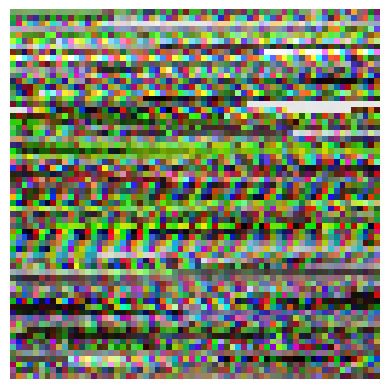

In [29]:
import matplotlib.pyplot as plt

# Example of a picture that was wrongly classified.
index = 25

# Display the image at the specified index in the test set.
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
plt.axis('off')  # Hide axes for better visualization

# Print the true label and the predicted label for the image.
true_label = test_set_y[0, index]
predicted_label_index = int(model_results["Y_prediction_test"][0, index])  # Convert to integer
predicted_label = classes[predicted_label_index].decode('utf-8')  # Decode for proper string format

print(f"y = {true_label}, you predicted that it is a \"{predicted_label}\" picture.")

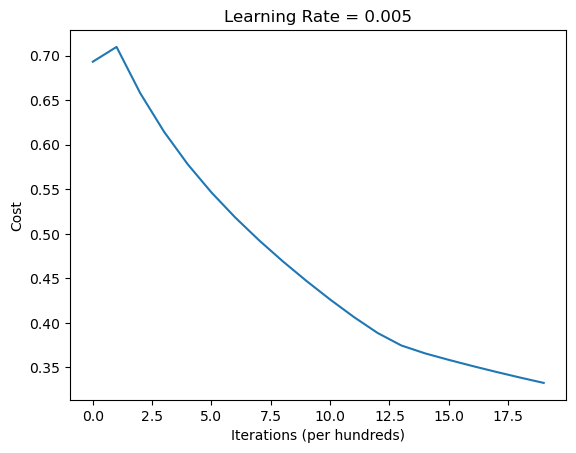

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Plot learning curve (costs over iterations)
costs = np.squeeze(model_results['costs'])  # Extract and flatten the array of costs

plt.plot(costs)  # Plot the cost values
plt.ylabel('Cost')  # Label for the y-axis
plt.xlabel('Iterations (per hundreds)')  # Label for the x-axis
plt.title(f"Learning Rate = {model_results['learning_rate']}")  # Plot title with the learning rate
plt.show()  # Display the plot

### 6 - Further analysis

#### Choose learning rate

Learning rate is: 0.01
Train accuracy: 71.29 %
Test accuracy: 34.00 %

-------------------------------------------------------

Learning rate is: 0.001
Train accuracy: 74.16 %
Test accuracy: 34.00 %

-------------------------------------------------------

Learning rate is: 0.0001
Train accuracy: 66.03 %
Test accuracy: 34.00 %

-------------------------------------------------------



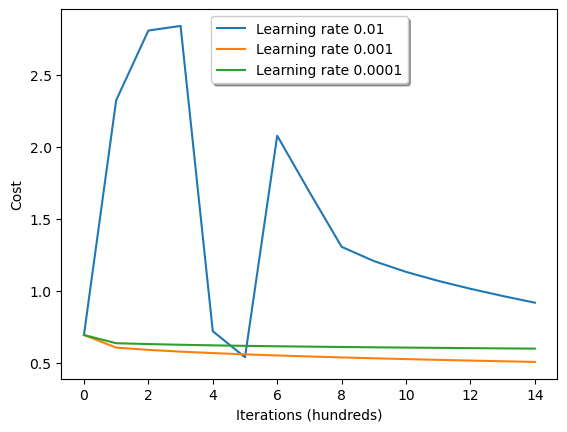

In [33]:
# List of learning rates to evaluate
learning_rates = [0.01, 0.001, 0.0001]

# Dictionary to store models for each learning rate
models = {}

# Train models for each learning rate
for lr in learning_rates:
    print(f"Learning rate is: {lr}")
    # Store the model's output in the dictionary using the learning rate as the key
    models[str(lr)] = model(
        train_set_x, train_set_y, 
        test_set_x, test_set_y, 
        num_iterations=1500, 
        learning_rate=lr, 
        print_cost=False
    )
    print("\n" + "-" * 55 + "\n")

# Plot the cost curves for each learning rate
for lr in learning_rates:
    # Squeeze to flatten the array of costs and plot it
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=f"Learning rate {lr}")

# Set plot labels and title
plt.ylabel('Cost')
plt.xlabel('Iterations (hundreds)')

# Display the legend in the plot
plt.legend(loc='upper center', shadow=True, frameon=True)
plt.show()


### 7 - Test with your own image

y = 0, your algorithm predicts a "b'non-cat'" picture.


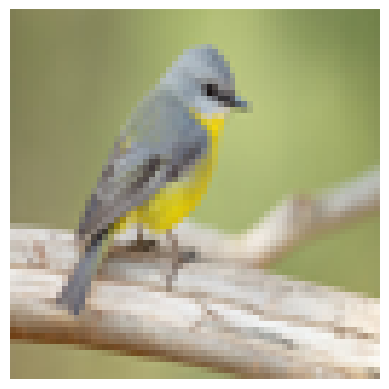

In [35]:
# Specify your image name
image_name = "non_cat.jpg"  # Update this to the name of your image file

# Preprocess the image to fit the model's input requirements
image_path = f"images/{image_name}"
image = np.array(Image.open(image_path))  # Read the image using PIL
image = image / 255.0  # Normalize pixel values to [0, 1]

# Resize the image to the model's expected input size and reshape for prediction
image_resized = np.array(Image.fromarray((image * 255).astype(np.uint8)).resize((num_px, num_px)))
my_image = image_resized.reshape((1, num_px * num_px * 3)).T

# Predict the label using the trained model
my_predicted_image = predict(model_results["w"], model_results["b"], my_image)

# Display the image
plt.imshow(image_resized)
plt.axis('off')  # Hide the axis for better visualization

# Print the prediction result
predicted_class = int(np.squeeze(my_predicted_image))
print(f"y = {predicted_class}, your algorithm predicts a \"{classes[predicted_class]}\" picture.")